In [42]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
import scipy as sp
import scipy.stats as sps
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
import math
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy import linalg as LA
from scipy.linalg import eigvals as eig
import seaborn as sns
from collections import Counter
from statsmodels.sandbox.stats.multicomp import multipletests
from tqdm import tqdm_notebook
import gc
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from scipy.linalg import eigvals
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb
from xgboost import XGBClassifier
from collections import defaultdict
from dateutil.parser import parse
import requests
import pandas as pd
import time
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
sns.set()
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
def execute_query(query, cluster, alias, token, timeout=600):
    proxy = "http://{}.yt.yandex.net".format(cluster)
    s = requests.Session()
    url = "{proxy}/query?database={alias}&password={token}&enable_optimize_predicate_expression=0".format(proxy=proxy, alias=alias, token=token)
    resp = s.post(url, data=query, timeout=timeout)
    resp.raise_for_status()
    rows = resp.text.strip().split('\n')
    return rows

def chyt_execute_query(query, cluster, alias, token, columns):
    i = 0
    while True:
        try:
            result = execute_query(query=query, cluster=cluster, alias=alias, token=token)
            users = pd.DataFrame([row.split('\t') for row in result], columns = columns)
            return users
        except Exception as err:
            print(err)
            i += 1
            if i > 2:
                print('Break Excecution')
                break

cluster = "hahn"
alias = "*cloud_analytics"
token = ''

In [3]:
target_request ="""
SELECT
    billing_account_id, 
    hasAll(['unreachible', 'unreachible,unreachible'], arr) as target
FROM (
    SELECT
        billing_account_id,
        groupUniqArray(call_status) as arr
    FROM "//home/cloud_analytics_test/cubes/crm_leads/cube"
    WHERE 
        event == 'call'
    AND
        isNotNull(billing_account_id)
    GROUP BY billing_account_id
);
"""
data_req = """
    SELECT
        DISTINCT
            puid,
            billing_account_id,
            max(first_first_trial_consumption_datetime) as start_trial_dt,
            sum(trial_consumption) as all_trial_consumption,
            anyLast(ba_state) as last_state,
            anyLast(ba_usage_status) as ba_usage_status,
            anyLast(ba_type) as ba_type,
            anyLast(ba_person_type) as ba_person_type,
            max(segment) as segment,
            max(if (device_model like '%iPhone%', 1, 0)) as is_IPhone,
            max(if (age == 'undefined', null, age)) as age,
            max(if (city == 'undefined', null, city)) as city,
            max(if (country == 'undefined', null, country)) as country,
            max(if (sex == 'undefined', null, sex)) as sex,
            maxdt
    FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
    INNER JOIN (
        SELECT
            puid,
            billing_account_id,
            addDays(max(toDateTime(first_first_trial_consumption_datetime)), 7) as maxdt
        FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
        WHERE isNotNull(first_first_trial_consumption_datetime)
        Group by puid, billing_account_id
    )
    ON puid == puid
    WHERE 
        toDateTime(event_time) <= maxdt
    AND
        isNotNull(billing_account_id)
    AND 
        event in ('ba_created', 'day_use')
    Group by puid, billing_account_id, maxdt;
"""
consumption_req = """
SELECT
    billing_account_id,
    array_cons[1] as day_1,
    array_cons[2] as day_2,
    array_cons[3] as day_3,
    array_cons[4] as day_4,
    array_cons[5] as day_5,
    array_cons[6] as day_6,
    array_cons[7] as day_7,
    if (isNull(page_views), 0, page_views) as page_views
FROM (
    SELECT
        billing_account_id,
        arrayResize(groupArray(day_trial_consumption), 7, 0) as array_cons,
        max(page_views) as page_views
    FROM (
        SELECT
            billing_account_id,
            sum(trial_consumption) as day_trial_consumption,
            dateDiff('day', toDateTime(first_first_trial_consumption_datetime), toDateTime(event_time)) as delta,
            max(page_views) as page_views
        FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
        INNER JOIN (
            SELECT
                puid,
                billing_account_id,
                addDays(max(toDateTime(first_first_trial_consumption_datetime)), 7) as maxdt
            FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
            WHERE isNotNull(first_first_trial_consumption_datetime)
            AND name NOT LIKE '%public_fips%' AND
            name NOT LIKE '%public_ip%' AND 
            name NOT LIKE '%image%' AND
            name NOT LIKE '%snapshot%' AND 
            name NOT LIKE '%network-hdd%' AND 
            name NOT LIKE '%network-nvme%' AND
            event like 'day_use'
            Group by puid, billing_account_id
        )
        ON puid == puid
        WHERE 
            toDateTime(event_time) <= maxdt
        AND
            delta >= 0
        AND
            delta < 7
        AND
            isNotNull(billing_account_id)
        Group by billing_account_id, maxdt, delta
        ORDER BY billing_account_id, delta
    )
    GROUP BY billing_account_id
);
"""

In [4]:
def city_country_maker(row):
    val = row["country"]
    if val == 'unknown':
        return 'unknown'
    if val == "Россия":
        if row["city"] in ['Москва', 'Санкт-Петербург']:
            return row["city"]
        return val
    if val in ["Украина", "Армения", "Казахстан", "Беларусь"]:
        return "СНГ"
    else:
        return "иностранная"

In [5]:
def ba_person_type_maker(x):
    if x == 'switzerland_nonresident_company':
        return 'company'
    else:
        return x

In [6]:
def last_state_maker(x):
    if x == 'inactive' or x == 'payment_required':
        return 'suspended'
    return x

In [7]:
def segment_maker(x):
    if 'isv' in x:
        return 'isv'
    return x

In [8]:
def make_category(df, column):
    df[column] = df[column].replace(np.nan, "unknown")
    df[column] = df[column].astype(str)
    dummies = pd.get_dummies(df[column])
    dummies.columns = [column  + "_"+ col for col in dummies.columns]
    df = pd.concat([df, dummies], axis = 1)
    changer = df.groupby(column)["target"].mean()
    changer = changer.to_dict()
    df[column] = df[column].replace(changer)
    return df

In [9]:
def active_days_finder(row):
    day_num = 7
    while day_num >= 1 and row["day_" + str(day_num)] < 0.5:
        day_num -= 1
    return day_num

In [10]:
def mean_maker(row):
    num = row["active_days"]
    if num <= 1:
        return 0
    val = 0
    for i in range(1, num):
        val += row["day_" + str(i + 1)]
    return val / (num - 1)

In [11]:
def prepare_ml_table(curr_df):
    df = curr_df.copy()
    df = df.replace("\\N", np.nan)
    targets = df["target"].astype(int)
    df["target"] = targets
    df["country_city"] = df.apply(city_country_maker, axis = 1)
    df["segment"] = df["segment"].apply(segment_maker)
    df["last_state"] = df["last_state"].apply(last_state_maker)
    df["ba_person_type"] = df["ba_person_type"].apply(ba_person_type_maker)
    df.drop(columns = ["maxdt", "start_trial_dt", "puid", "city", "country", 'ba_usage_status'], inplace = True)
    for i in range(1, 8):
        df["day_" + str(i)] = df["day_" + str(i)].astype(float)
    df["active_days"] = df.apply(active_days_finder, axis = 1)
    df["mean"] = df.apply(mean_maker, axis = 1)
    cat_cols = ["last_state", "segment", "ba_type", "ba_person_type", "age", "country_city", "sex"]
    for col in cat_cols:
        df = make_category(df, col)
    df.drop(columns = ["target"], inplace= True)
    for col in set(df.columns) - set(cat_cols) - set(["bid"]):
        df[col] = df[col].astype(float)
    df["target"] = targets
    return df

In [12]:
def create_data_table():
    target_columns = ["bid", "target"]
    target_df = chyt_execute_query(query=target_request, 
                                          cluster=cluster, alias=alias, token=token, columns=target_columns)
    data_columns = ["puid", "bid", "start_trial_dt", 
                    "all_trial_consumption", "last_state",
                    "ba_usage_status", "ba_type", "ba_person_type", "segment", "is_IPhone",
                    "age", "city", "country", "sex", "maxdt"]
    data_df = chyt_execute_query(query=data_req, 
                                          cluster=cluster, alias=alias, token=token, columns=data_columns)
    consumption_columns = ["bid", "day_1", "day_2", "day_3", "day_4", "day_5", "day_6", "day_7", "page_views"]
    consumption_df = chyt_execute_query(query=consumption_req, 
                                      cluster=cluster, alias=alias, token=token, columns=consumption_columns)
    temp = pd.merge(data_df, consumption_df, on = "bid")
    person_df = pd.merge(temp, target_df, on = "bid")
    ml_person_df = prepare_ml_table(person_df)
    return person_df, ml_person_df

In [13]:
person_df, ml_person_df = create_data_table()

In [14]:
pd.set_option("max_columns", 50)
person_df.head()

,puid,bid,start_trial_dt,all_trial_consumption,last_state,ba_usage_status,ba_type,ba_person_type,segment,is_IPhone,age,city,country,sex,maxdt,day_1,day_2,day_3,day_4,day_5,day_6,day_7,page_views,target
0,1130000036694058,dn2dd5t27ogmrf2vndjh,2019-01-30 23:59:57,792.3191914829999,active,trial,self-served,individual,mass,0,18-24,Архангельск,Россия,male,2019-02-06 23:59:57,94.09646147,384.74308314499996,62.716150559,62.733348403,62.74628385599999,62.57328434099999,62.710579709,3,1
1,935336239,dn2r2deohi5nuhsnhto1,2019-09-13 23:59:57,212.19602141800004,active,trial,self-served,individual,mass,0,35-44,Хабаровск,Россия,male,2019-09-20 23:59:57,23.061643873999998,31.531787543999997,31.531787543999997,31.526181491999996,31.531787542999997,31.480834209,31.531999212,10,0
2,2076165,dn2bksllb5bmtvion239,2019-08-13 23:59:57,881.710706585,active,trial,self-served,individual,mass,0,45-54,Омск,Россия,male,2019-08-20 23:59:57,81.53855752000001,133.365215174,133.355563768,133.35556376800002,133.365215166,133.36521516,133.365376029,10,0
3,114253769,dn2n8e8ek4ou9hs8geb8,2019-04-07 23:59:57,31.527712114999996,active,trial,self-served,individual,mass,0,24-34,Сухой Лог,Россия,male,2019-04-14 23:59:57,3.6715717469999998,13.437452300999999,14.418688067,0,0,0,0,11,0
4,232038677,dn2o2fpr9b7qnpetht6l,2019-04-26 23:59:57,120.80643924699997,active,trial,self-served,individual,mass,0,24-34,Москва,Россия,male,2019-05-03 23:59:57,7.032505177,18.752983225,18.569916989,18.752500656000002,18.952969392,19.372781904,19.372781904,36,0


In [15]:
ml_person_df.head()

,bid,all_trial_consumption,last_state,ba_type,ba_person_type,segment,is_IPhone,age,sex,day_1,day_2,day_3,day_4,day_5,day_6,day_7,page_views,country_city,active_days,mean,last_state_active,last_state_payment_not_confirmed,last_state_suspended,segment_csm,segment_enterprise,segment_isv,segment_mass,segment_var,segment_yandex_staff,ba_type_invoiced,ba_type_self-served,ba_person_type_company,ba_person_type_individual,age_0-17,age_18-24,age_24-34,age_35-44,age_45-54,age_55+,age_unknown,country_city_Москва,country_city_Россия,country_city_СНГ,country_city_Санкт-Петербург,country_city_иностранная,sex_female,sex_male,sex_unknown,target
0,dn2dd5t27ogmrf2vndjh,792.319191,0.326832,0.333159,0.356394,0.334847,0.0,0.368833,0.270988,94.096461,384.743083,62.716151,62.733348,62.746284,62.573284,62.710580,3.0,0.325180,7.0,116.370455,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,dn2r2deohi5nuhsnhto1,212.196021,0.326832,0.333159,0.356394,0.334847,0.0,0.205230,0.270988,23.061644,31.531788,31.531788,31.526181,31.531788,31.480834,31.531999,10.0,0.325180,7.0,31.522396,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,dn2bksllb5bmtvion239,881.710707,0.326832,0.333159,0.356394,0.334847,0.0,0.234201,0.270988,81.538558,133.365215,133.355564,133.355564,133.365215,133.365215,133.365376,10.0,0.325180,7.0,133.362025,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,dn2n8e8ek4ou9hs8geb8,31.527712,0.326832,0.333159,0.356394,0.334847,0.0,0.255063,0.270988,3.671572,13.437452,14.418688,0.000000,0.000000,0.000000,0.000000,11.0,0.325180,3.0,13.928070,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,dn2o2fpr9b7qnpetht6l,120.806439,0.326832,0.333159,0.356394,0.334847,0.0,0.255063,0.270988,7.032505,18.752983,18.569917,18.752501,18.952969,19.372782,19.372782,36.0,0.261216,7.0,18.962322,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [16]:
def transform_y_into_int_array(y):
    return np.array(y.astype(int))

In [30]:
X = ml_person_df.drop(columns = ["bid", "target"])
y = ml_person_df["target"]

train_x, test_x, train_y, test_y = train_test_split(X, y, random_state = 42, test_size = 0.25)

In [43]:
def apply_scale_model(x, *, is_train, scaler = None):
    if is_train:
        scaler = StandardScaler().fit(x)
    scaled_x = scaler.transform(x)
    return scaled_x, scaler

In [44]:
def apply_one_class_svm_model(x, *, is_train, train_y = None, one_class_svm = None):
    if is_train:
        inds = np.where(train_y == 0)[0]
        x_train = x[inds]
        one_class_svm = OneClassSVM(nu = 0.3, random_state=42).fit(x_train)
    return ((np.ones(x.shape[0]) - one_class_svm.predict(x)) / 2).astype(int), one_class_svm
        

In [45]:
def apply_supporting_models_main_karkas(x, *, training, train_y = None, models):
    scaled_x, scaler = apply_scale_model(x, is_train = training, scaler = models.get("scale_model"))
    y_svm_answers, one_class_svm = apply_one_class_svm_model(scaled_x, is_train = training, 
                                                             train_y = train_y, 
                                                             one_class_svm = models.get("one_class_svm"))
    scaled_x = np.concatenate([scaled_x, y_svm_answers.reshape(-1, 1)], axis = 1)
    return scaled_x, {"scale_model": scaler, "one_class_svm" : one_class_svm}

In [46]:
def train_and_apply_supporting_models(train_x, train_y):
    return apply_supporting_models_main_karkas(train_x, training = True, train_y = train_y, models = {})

In [47]:
def apply_supporting_models_to_test(test_x, **models):
    return apply_supporting_models_main_karkas(test_x, training = False, models = models)

In [48]:
def find_best_params(scaled_train_x, train_y, model_type, params):
    grid_model = GridSearchCV(model_type(), params, cv = 4, n_jobs = -1, scoring = "precision")
    grid_model.fit(scaled_train_x, train_y)
    return grid_model.best_params_

In [49]:
def visualize_mistakes(train_y, y_proba_train_predict, test_y, y_proba_test_predict):
    plt.figure(figsize = (20, 10))
    e = [ans[1 - y] for y, ans in zip(test_y, y_proba_test_predict)]
    plt.subplot(1, 2, 2)
    plt.title("Распеделение ошибок", fontsize = 15)
    sns.distplot(e, hist = True, color = 'lime', label = "test")
    e = [ans[1 - y] for y, ans in zip(train_y, y_proba_train_predict)]
    sns.distplot(e, hist = True, color = 'red', label = "train")
    plt.legend(fontsize = 20)
    plt.show()

In [50]:
class BlendingClassifier:
    def __init__(self, *models, weights = None):
        self.models = models
        self.weights = np.array(weights)
        if weights is None:
            self.weights = np.ones(len(models)) / len(models)
        assert self.weights.shape[0] == len(self.models)
        
    def predict_proba(self, x_test):
        x_test_copy = np.array(x_test)
        ans = np.zeros((x_test_copy.shape[0], 2))
        for model, weight in zip(self.models, self.weights):
            ans += model.predict_proba(x_test_copy) * weight
        return ans
    
    def predict(self, x_test, thr = 0.5):
        ans = self.predict_proba(x_test)
        return np.array(ans[:, 1] >= thr).astype(int)

    def calculate_metrics(self, x_test, test_y,  thr = 0.5):
        y_predict = self.predict(x_test, thr)
        print(f"accuracy score: {round(accuracy_score(test_y, y_predict), 3) * 100}")
        print(f"precision score: {round(precision_score(test_y, y_predict), 3) * 100}")
        print(f"recall_score: {round(recall_score(test_y, y_predict), 3) * 100}")
        print(f"f1_score: {round(f1_score(test_y, y_predict), 3) * 100}")
        
    def visualize_mistakes(self, train_y, train_x, test_y, test_x):
        y_proba_train_predict = self.predict_proba(train_x)
        y_proba_test_predict = self.predict_proba(test_x)
        visualize_mistakes(train_y, y_proba_train_predict, test_y, y_proba_test_predict)

In [51]:
def model_creator(scaled_train_x, train_y, scaled_test_x, test_y, model_type, params, need_visualize = False):
    gc.collect()
    best_params = find_best_params(scaled_train_x, train_y, model_type, params)
    gc.collect()
    model = model_type(**best_params).fit(scaled_train_x, train_y)

    y_proba_test_predict = model.predict_proba(scaled_test_x)
    y_proba_train_predict = model.predict_proba(scaled_train_x)
    y_predict = model.predict(scaled_test_x)
    if need_visualize:
        print(f"accuracy score: {round(accuracy_score(test_y, y_predict), 3) * 100}")
        print(f"precision score: {round(precision_score(test_y, y_predict), 3) * 100}")
        print(f"recall_score: {round(recall_score(test_y, y_predict), 3) * 100}")
        print(f"f1_score: {round(f1_score(test_y, y_predict), 3) * 100}")
        visualize_mistakes(train_y, y_proba_train_predict, test_y, y_proba_test_predict)
    return model

In [52]:
def final_model_creator(train_x, train_y, test_x, test_y = None, need_visualize = False):
    train_y = transform_y_into_int_array(train_y)
    test_y = transform_y_into_int_array(test_y)
    scaled_train_x, models = train_and_apply_supporting_models(train_x, train_y)
    scaled_test_x, models = apply_supporting_models_to_test(test_x, **models)
    need_visualize = need_visualize * (y is not None)
    print("XGBClassifier:")
    xgbclassifier = model_creator(
                                    scaled_train_x, train_y,\
                                    scaled_test_x, test_y,\
                                    XGBClassifier, \
                                    {"max_depth": [2, 3, 4], "n_estimators": [500, 800, 1400], 
                                     "learning_rate": [0.01, 0.03, 0.05],
                                     "seed": [1337], "random_state": [42]},
                                    need_visualize = need_visualize)
    print("==========================================")
    print("RandomForestClassifier:")
    random_forest_classifier = model_creator(
                                scaled_train_x, train_y,\
                                scaled_test_x, test_y,\
                                RandomForestClassifier, \
                                {"max_depth": [5, 10, 15, 20], "n_estimators": [2000],
                                 "random_state": [42]},
                                need_visualize = need_visualize)
    print("==========================================")
    print("CatBoostClassifier:")
    cat_boost_classifier = model_creator(
                                scaled_train_x, train_y,\
                                scaled_test_x, test_y,\
                                CatBoostClassifier, \
                                {"iterations": [1000],
                                 "depth": [1, 2, 3], 
                                 "bootstrap_type": ['Bernoulli'],
                                 "subsample": [0.2, 0.3, 0.5],
                                 "learning_rate": [0.01, 0.03, 0.05],
                                 "random_state": [42],
                                 "verbose": [False]},
                                need_visualize = True)
    blending_classifier = BlendingClassifier(xgbclassifier, random_forest_classifier, cat_boost_classifier)
    predicted_y = blending_classifier.predict(scaled_test_x)
    print("==========================================")
    if need_visualize:
        print("final BlendingClassifier:")
        blending_classifier.calculate_metrics(scaled_test_x, test_y)
        blending_classifier.visualize_mistakes(train_y, scaled_train_x, test_y, scaled_test_x)
        print("==========================================")
    return predicted_y, blending_classifier

XGBClassifier:
accuracy score: 72.3
precision score: 67.80000000000001
recall_score: 31.7
f1_score: 43.2


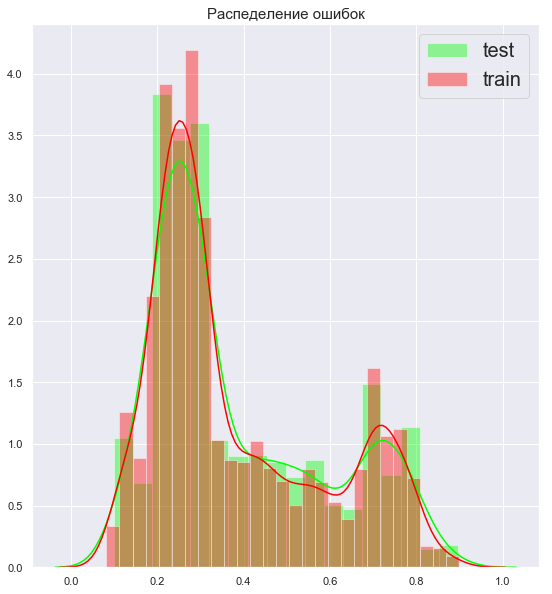

RandomForestClassifier:
accuracy score: 72.6
precision score: 69.1
recall_score: 31.7
f1_score: 43.4


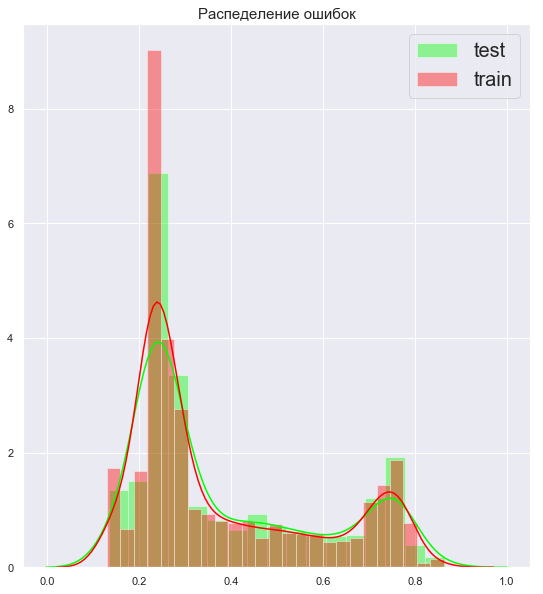

CatBoostClassifier:
accuracy score: 73.5
precision score: 69.8
recall_score: 35.3
f1_score: 46.9


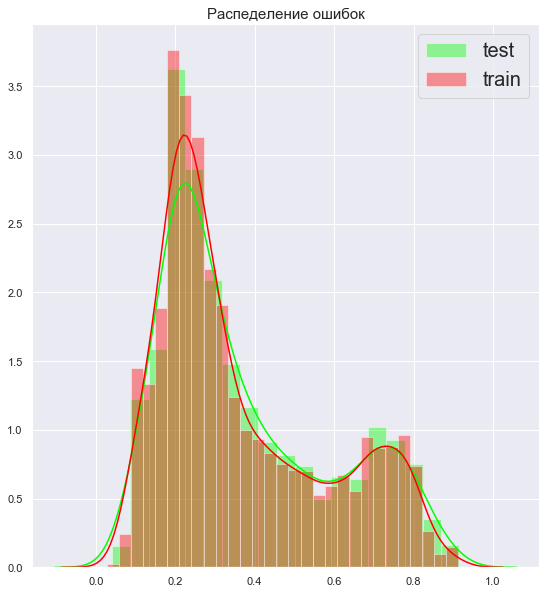

final BlendingClassifier:
accuracy score: 73.2
precision score: 69.8
recall_score: 34.0
f1_score: 45.800000000000004


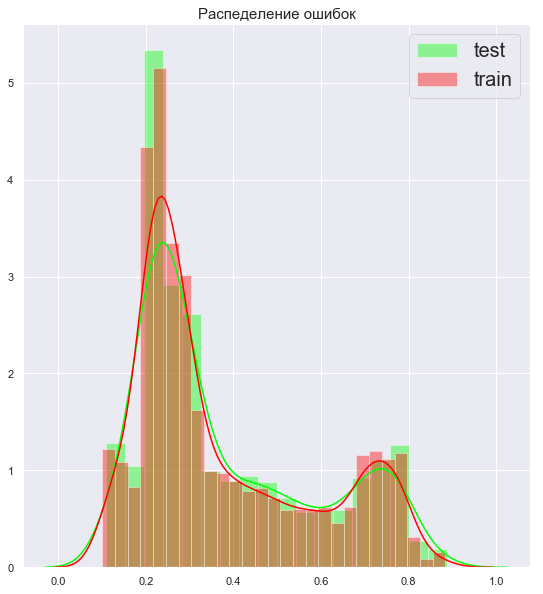

In [53]:
predicted_y, blending_classifier = final_model_creator(train_x, train_y, \
                                test_x, test_y, need_visualize = True)